In [25]:
library(diann)
library(tidyverse)
library(gtools)
library(grid)
library(gridExtra)


# import plot functions
source("../../evaluation_utils/plots/eda_plots.R")
source("../../evaluation_utils/preprocessing_raw/preprocessing_DIANN.R")
source("../../evaluation_utils/filtering/filtering_normalization.R")

In [26]:
rename_samples <- function(pg_matrix, metadata, name){
    # rename
    if (name == 'lab_A' | name == 'lab_E'){
      metadata$file <- sapply(strsplit(as.character(metadata$file), "_"), function(x) {
          if (length(x) == 4) {  # if there are four parts
            paste(x[2], x[4], sep = "_")
          } else {  # otherwise, there are three parts
            x[2]
          }
        })
      rownames(metadata) <- metadata$file
      colnames(pg_matrix) <- metadata$file
    }
    else if (name == 'lab_C') {
      metadata$file <- sapply(strsplit(as.character(metadata$file), "_"), function(x) {
          paste(x[5], x[6], sep = "_")
        })
      rownames(metadata) <- metadata$file
      colnames(pg_matrix) <- metadata$file
    
    } else if (name == 'lab_B') {
        metadata$file <- sapply(strsplit(as.character(metadata$file), "_"), function(x) {
          x[5]
        })
      rownames(metadata) <- metadata$file
      colnames(pg_matrix) <- metadata$file
    
    } else if (name == 'lab_D') {
      metadata$file <- sapply(strsplit(as.character(metadata$file), "_"), function(x) {
          x[8]
        })
      rownames(metadata) <- metadata$file
      colnames(pg_matrix) <- metadata$file
    }

    return(list(pg_matrix, metadata))
}


create_plots <- function(pg_matrix, metadata, name, plot_file_prefix){

    # log2 transform for plots
    pg_matrix <- pg_matrix %>% 
      mutate(across(everything(), 
                      ~ {.x <- log2(.)
                      replace(.x, .x < 0 | is.infinite(.x), NA)
                      }))
    
    # metadata_with_ref_samples <- create_metadata_with_ref(data, name)
    renaming_res <- rename_samples(pg_matrix, metadata, name)
    pg_matrix <- renaming_res[[1]]
    metadata <- renaming_res[[2]]

    # plots
    plot_pca <- pca_plot(pg_matrix, metadata, title=paste0(name, " PCA"), quantitative_col_name='file', col_col='condition', shape_col='lab')
    plot_boxplot <- boxplot_pg(pg_matrix, metadata, title=paste0(name, " Boxplot"), color_col='condition', quantitativeColumnName='file')
    plot_density <- plotIntensityDensityByPool(pg_matrix, metadata, title=paste0(name, " Density"), poolColumnName='condition', quantitativeColumnName='file')
    plot_heatmap <- heatmap_plot(pg_matrix, metadata, name)

    layout <- (plot_density | plot_pca) /
            (plot_boxplot | plot_heatmap)
    # save plot
    ggsave(file = paste0(plot_file_prefix, "_plots.svg"), plot = layout, width = 11, height = 10)
}

# Create datasets

In [27]:
datasets_list <- c("downsampled", "imbalanced")
filter_list_META = list("downsampled" = list(), "imbalanced" = list())
labs_list <- c("lab_A", "lab_B", "lab_C", "lab_D", "lab_E")

In [28]:
  samples_fractions <- list(
    "downsampled" = list(
      "lab_A" = c(9, 9),
      "lab_B" = c(8, 8),
      "lab_C" = c(8, 8),
      "lab_D" = c(9, 9),
      "lab_E" = c(9, 9)
    ),
    "imbalanced" = list(
      "lab_A" = c(4, 11),
      "lab_B" = c(8, 11),
      "lab_C" = c(3, 10),
      "lab_D" = c(12, 9),
      "lab_E" = c(11, 7)
      )
  )

In [29]:
get_sample_names <- function(name, batch_info, samples_number) {
  sample_sizes <- samples_number[[name]]
  set.seed(42)
  
  sample_names_pyr <- rownames(batch_info[batch_info$condition == 'Pyr', ][sample(1:nrow(batch_info[batch_info$condition == 'Pyr', ]), sample_sizes[1]), ])
  sample_names_glu <- rownames(batch_info[batch_info$condition == 'Glu', ][sample(1:nrow(batch_info[batch_info$condition == 'Glu', ]), sample_sizes[2]), ])
  
  c(sample_names_pyr, sample_names_glu)
}

Processing  lab_A  dataset:  downsampled 
[1] "file"      "lab"       "condition"
Number of proteins:  2549    Numer of samples:  18 
Filtering out features that have NAs in all columns
	Before filtering: 2549 18 
	After filtering: 2549 18 


No id variables; using all as measure variables

Warning message:
“Removed 1105 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1105 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1105 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2549 18 
Processing  lab_B  dataset:  downsampled 
[1] "file"      "lab"       "condition"
Number of proteins:  2845    Numer of samples:  16 
Filtering out features that have NAs in all columns
	Before filtering: 2845 16 
	After filtering: 2845 16 


No id variables; using all as measure variables



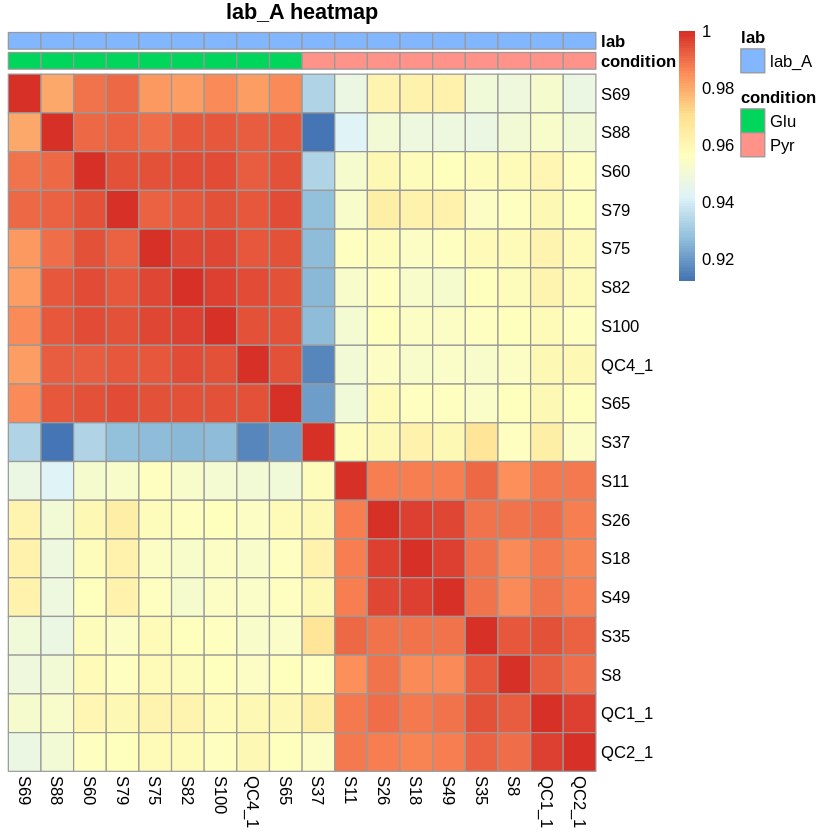

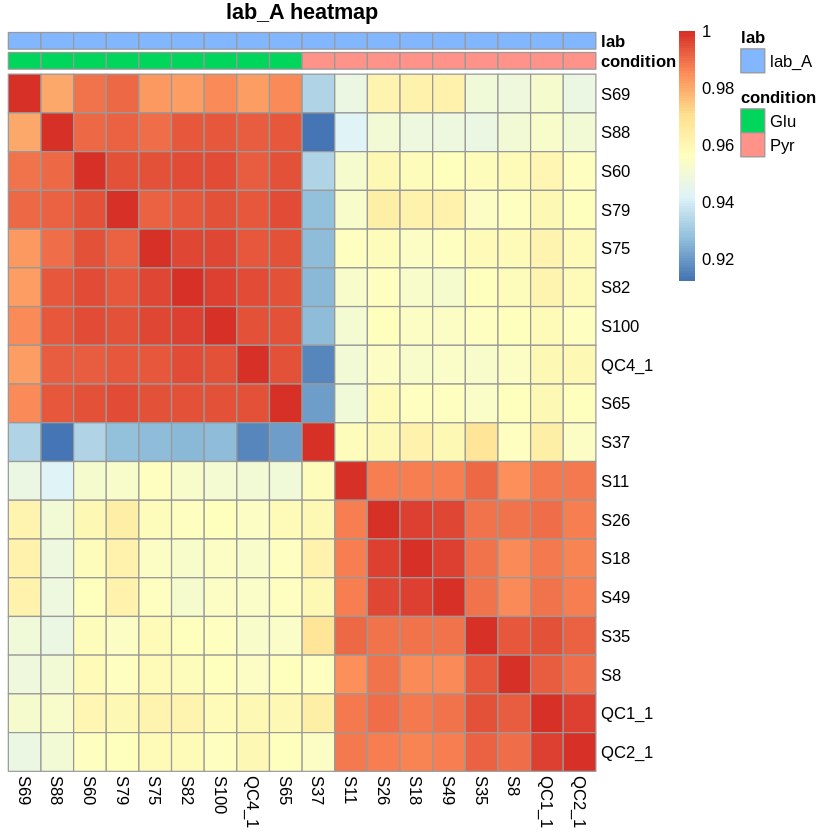

Warning message:
“Removed 841 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 841 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 841 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2845 16 
Processing  lab_C  dataset:  downsampled 
[1] "file"      "lab"       "condition"
Number of proteins:  2820    Numer of samples:  16 
Filtering out features that have NAs in all columns
	Before filtering: 2820 16 
	After filtering: 2820 16 


No id variables; using all as measure variables



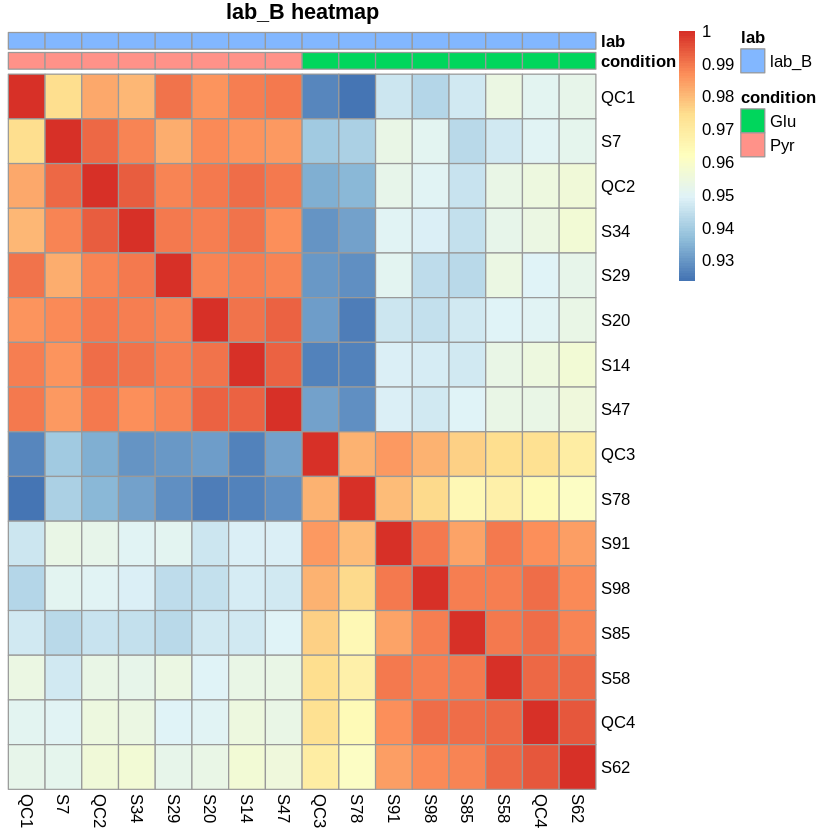

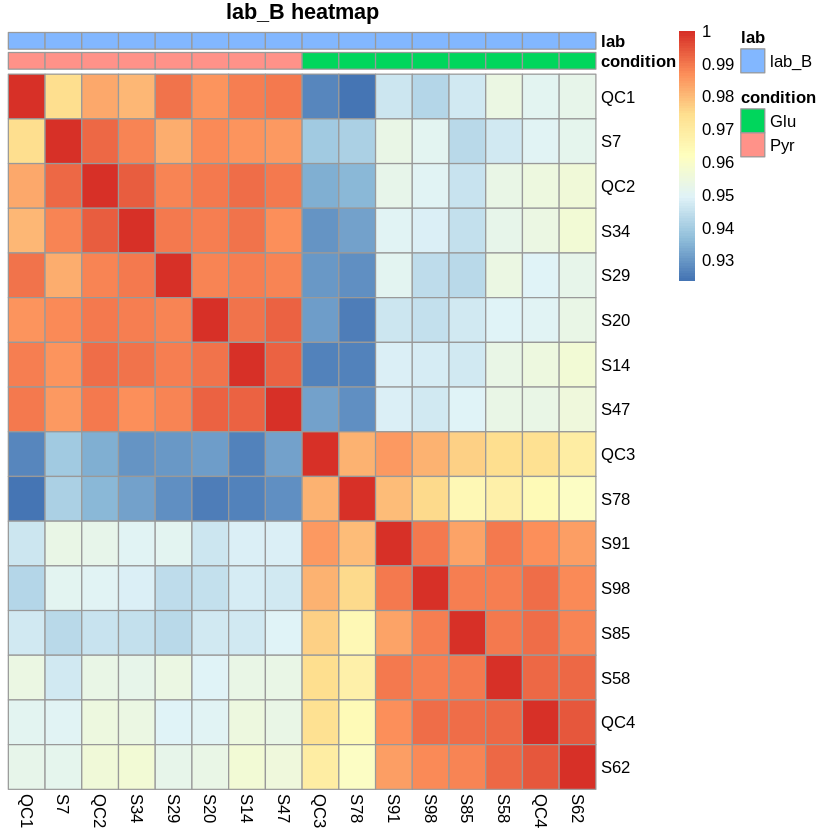

Warning message:
“Removed 1433 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1433 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1433 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2820 16 
Processing  lab_D  dataset:  downsampled 
[1] "file"      "lab"       "condition"
Number of proteins:  2813    Numer of samples:  18 
Filtering out features that have NAs in all columns
	Before filtering: 2813 18 
	After filtering: 2813 18 


No id variables; using all as measure variables



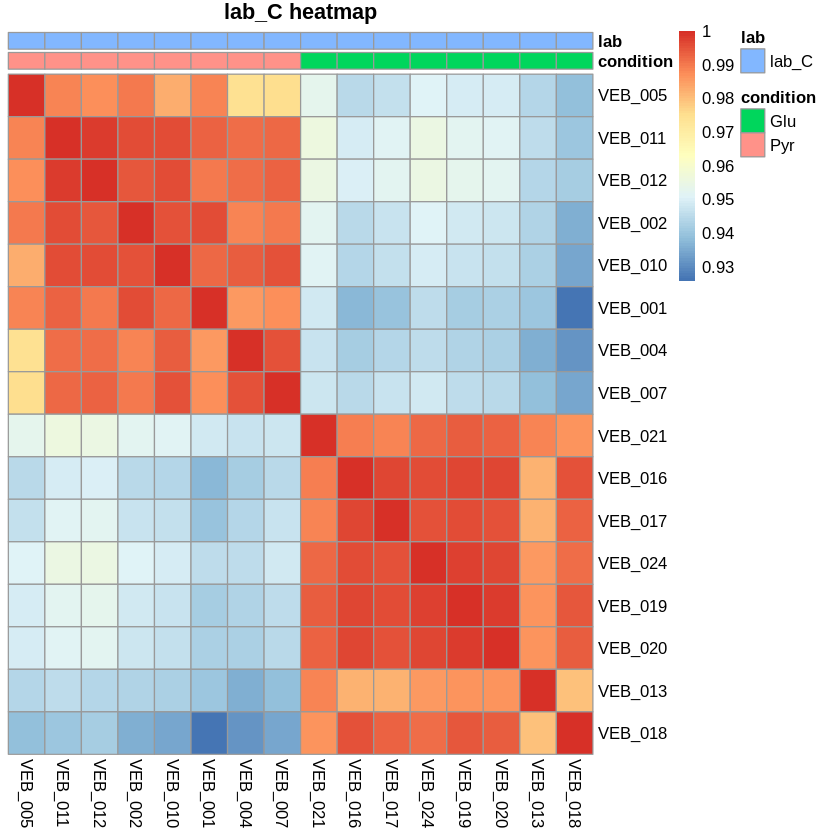

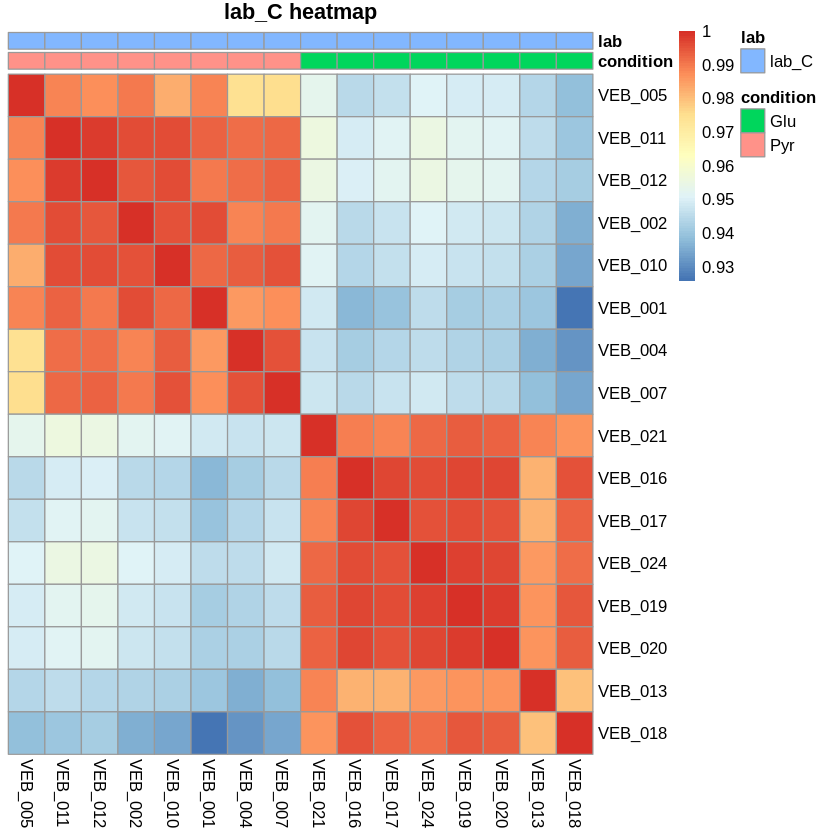

Warning message:
“Removed 775 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 775 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 775 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2813 18 
Processing  lab_E  dataset:  downsampled 
[1] "file"      "lab"       "condition"
Number of proteins:  2401    Numer of samples:  18 
Filtering out features that have NAs in all columns
	Before filtering: 2401 18 
	After filtering: 2401 18 


No id variables; using all as measure variables



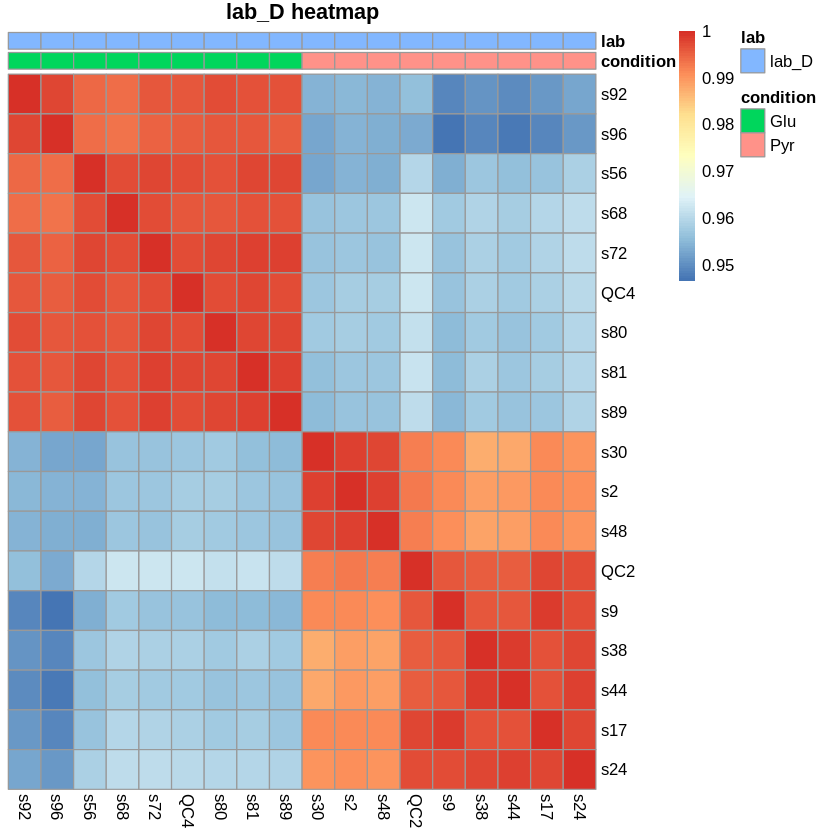

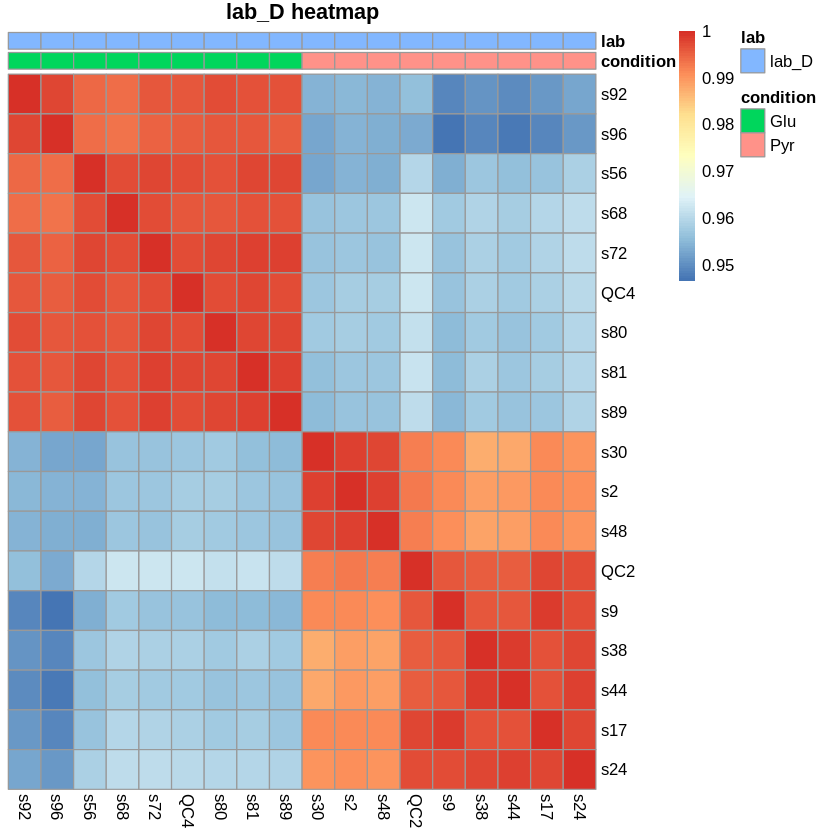

Warning message:
“Removed 879 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 879 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 879 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2401 18 
Processing  lab_A  dataset:  imbalanced 
[1] "file"      "lab"       "condition"
Number of proteins:  2548    Numer of samples:  15 
Filtering out features that have NAs in all columns
	Before filtering: 2548 15 
	After filtering: 2548 15 


No id variables; using all as measure variables



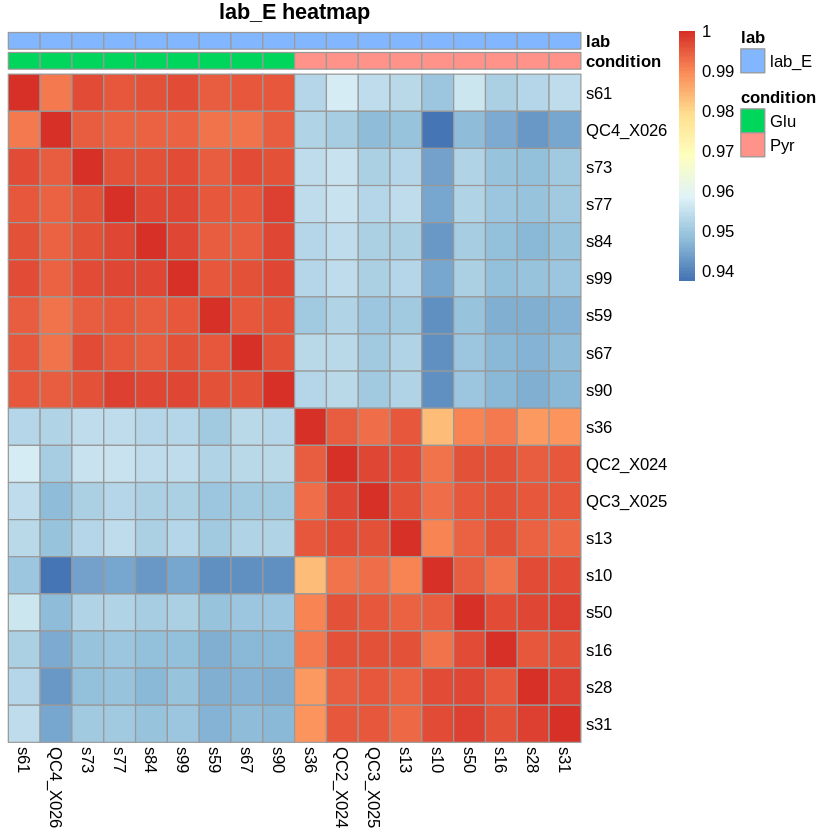

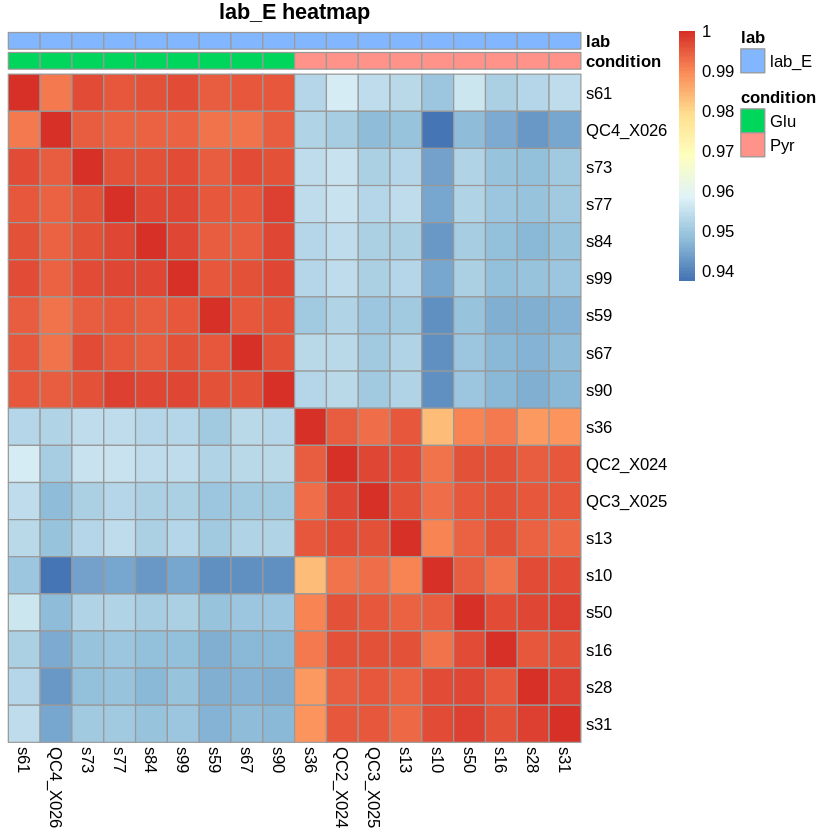

Warning message:
“Removed 914 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 914 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 914 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2548 15 
Processing  lab_B  dataset:  imbalanced 
[1] "file"      "lab"       "condition"
Number of proteins:  2846    Numer of samples:  19 
Filtering out features that have NAs in all columns
	Before filtering: 2846 19 
	After filtering: 2846 19 


No id variables; using all as measure variables



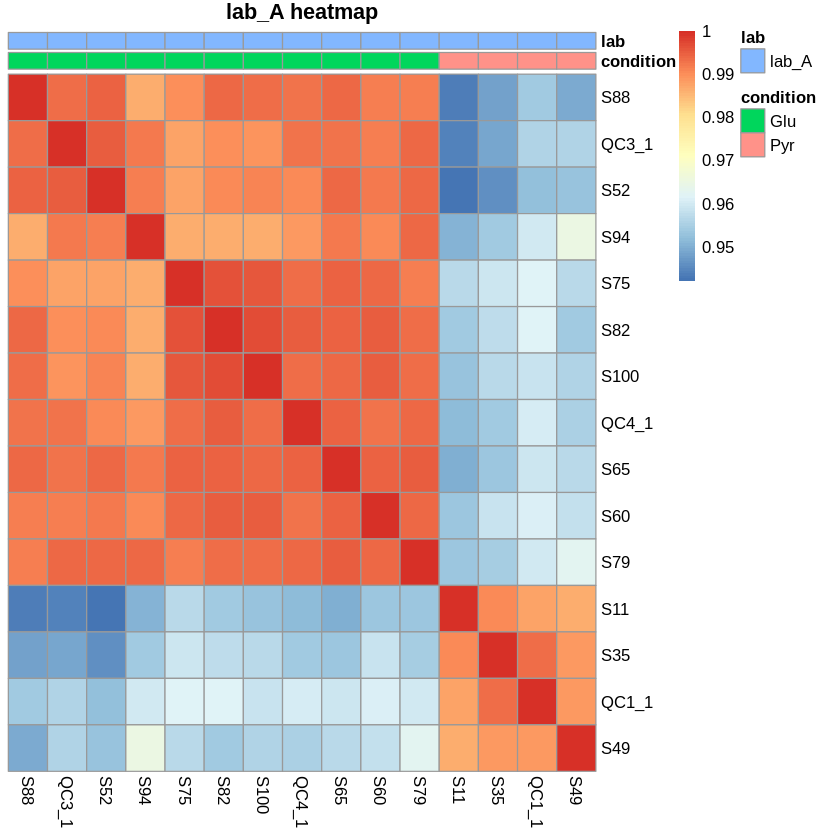

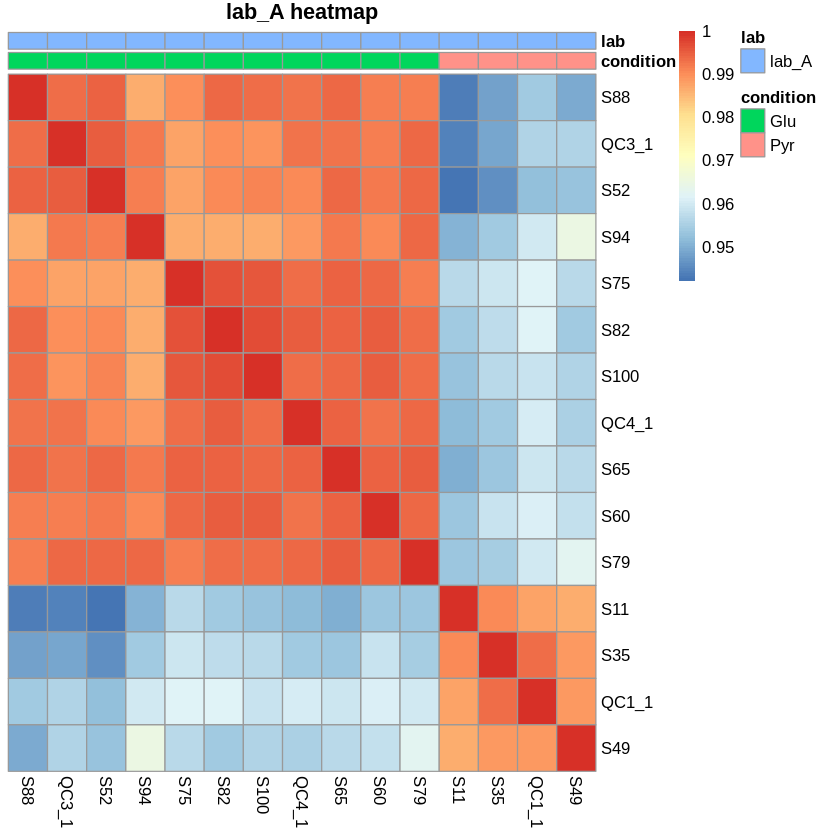

Warning message:
“Removed 1081 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1081 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1081 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2846 19 
Processing  lab_C  dataset:  imbalanced 
[1] "file"      "lab"       "condition"
Number of proteins:  2817    Numer of samples:  13 
Filtering out features that have NAs in all columns
	Before filtering: 2817 13 
	After filtering: 2817 13 


No id variables; using all as measure variables



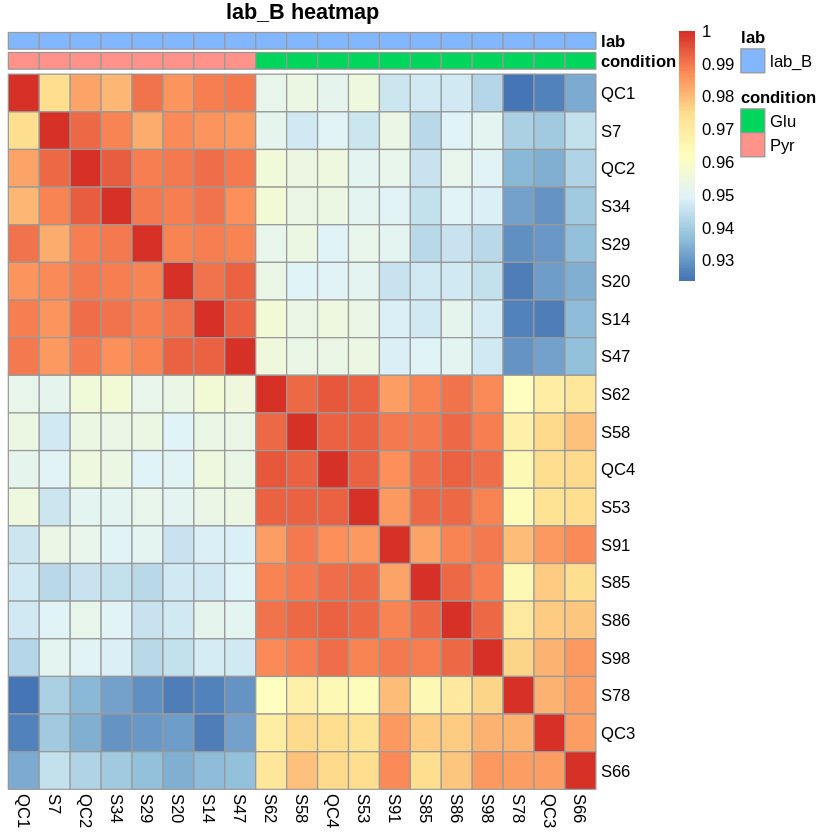

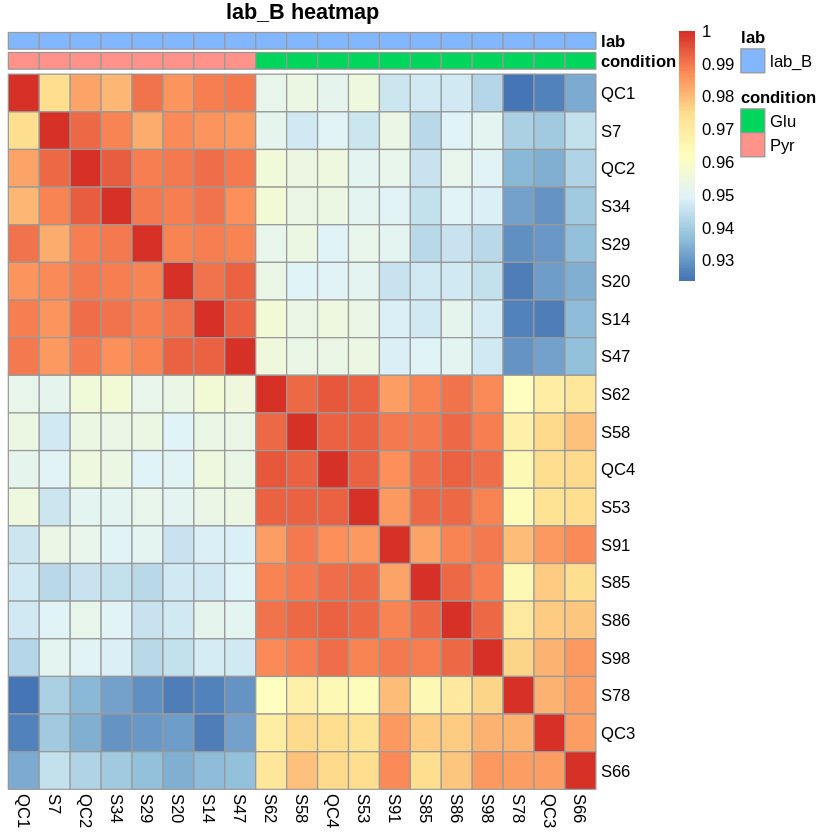

Warning message:
“Removed 1281 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 1281 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1281 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2817 13 
Processing  lab_D  dataset:  imbalanced 
[1] "file"      "lab"       "condition"
Number of proteins:  2813    Numer of samples:  21 
Filtering out features that have NAs in all columns
	Before filtering: 2813 21 
	After filtering: 2813 21 


No id variables; using all as measure variables



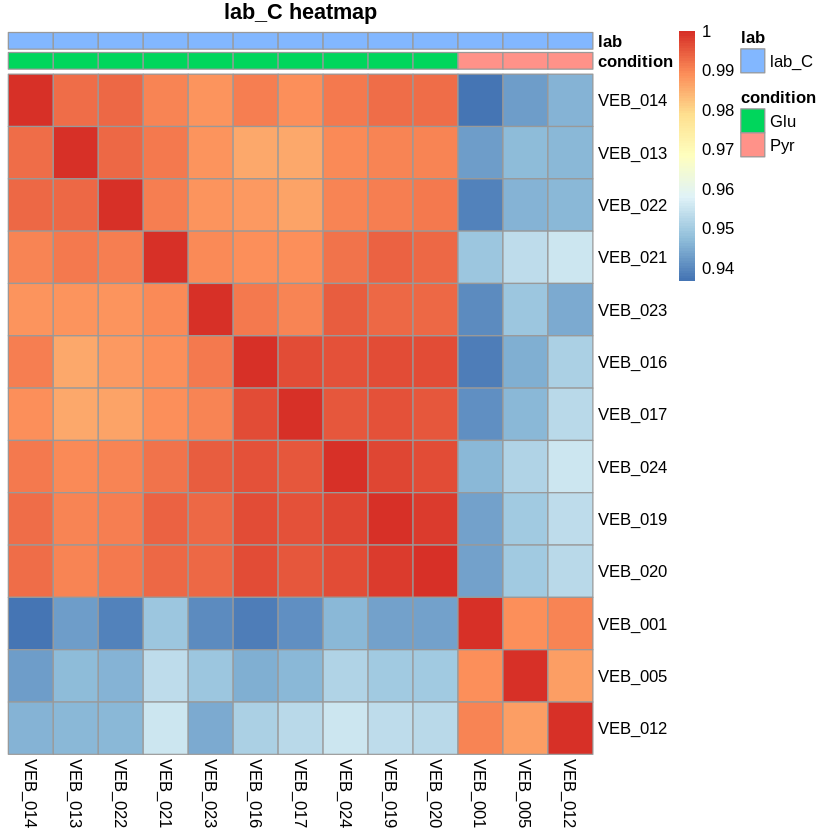

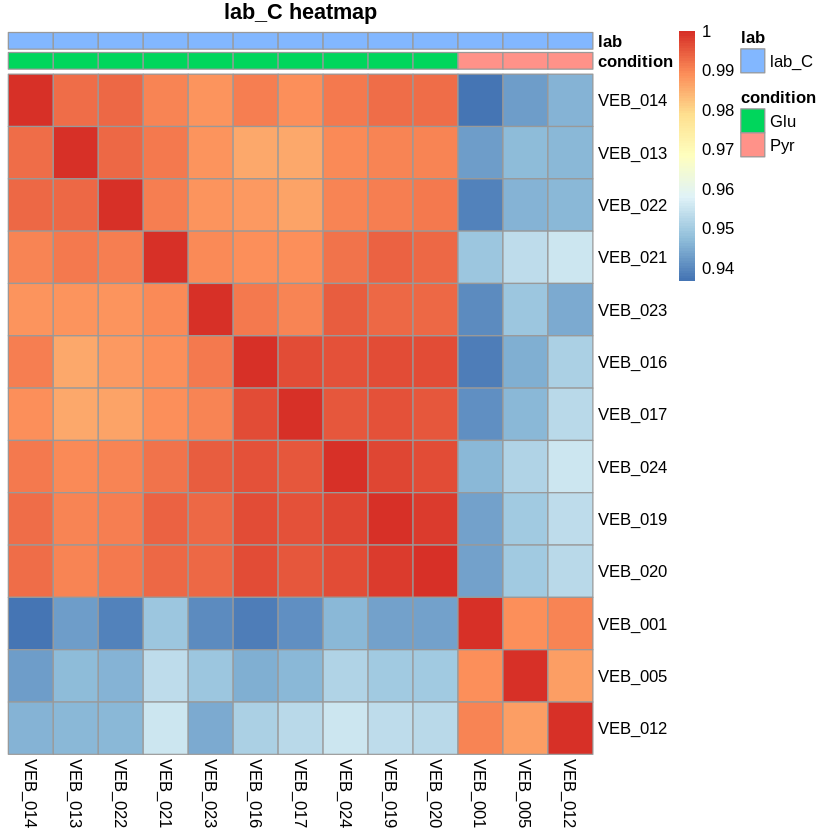

Warning message:
“Removed 865 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 865 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 865 rows containing non-finite values (`stat_summary()`).”


Dimensions of the matrix:  2813 21 
Processing  lab_E  dataset:  imbalanced 
[1] "file"      "lab"       "condition"
Number of proteins:  2401    Numer of samples:  18 
Filtering out features that have NAs in all columns
	Before filtering: 2401 18 
	After filtering: 2401 18 


No id variables; using all as measure variables



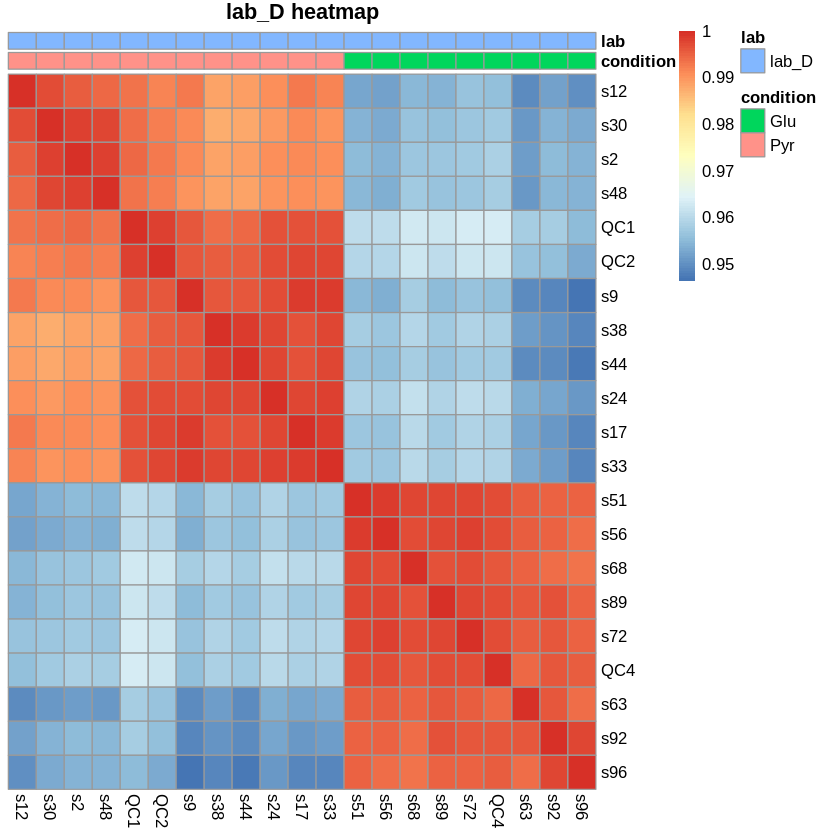

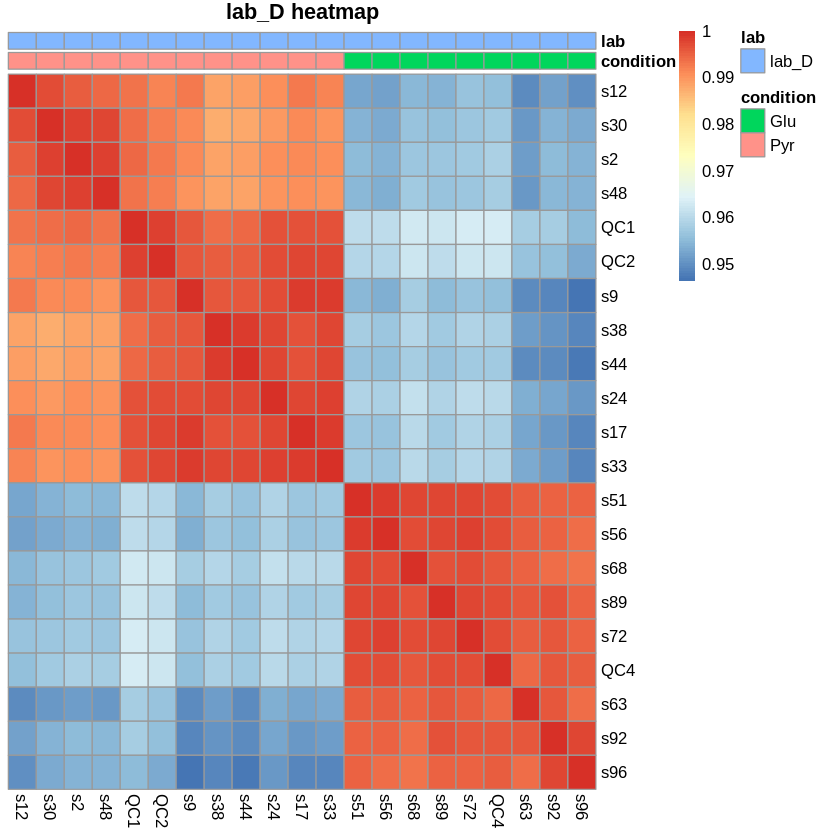

Warning message:
“Removed 834 rows containing non-finite values (`stat_density()`).”
Warning message:
“Removed 834 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 834 rows containing non-finite values (`stat_summary()`).”


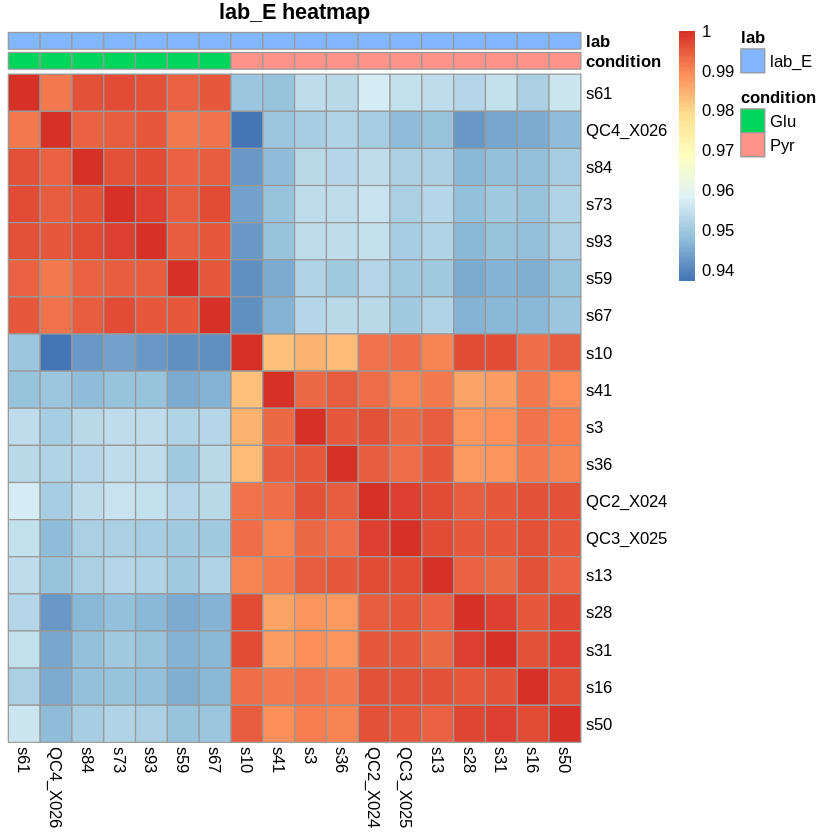

Dimensions of the matrix:  2401 18 


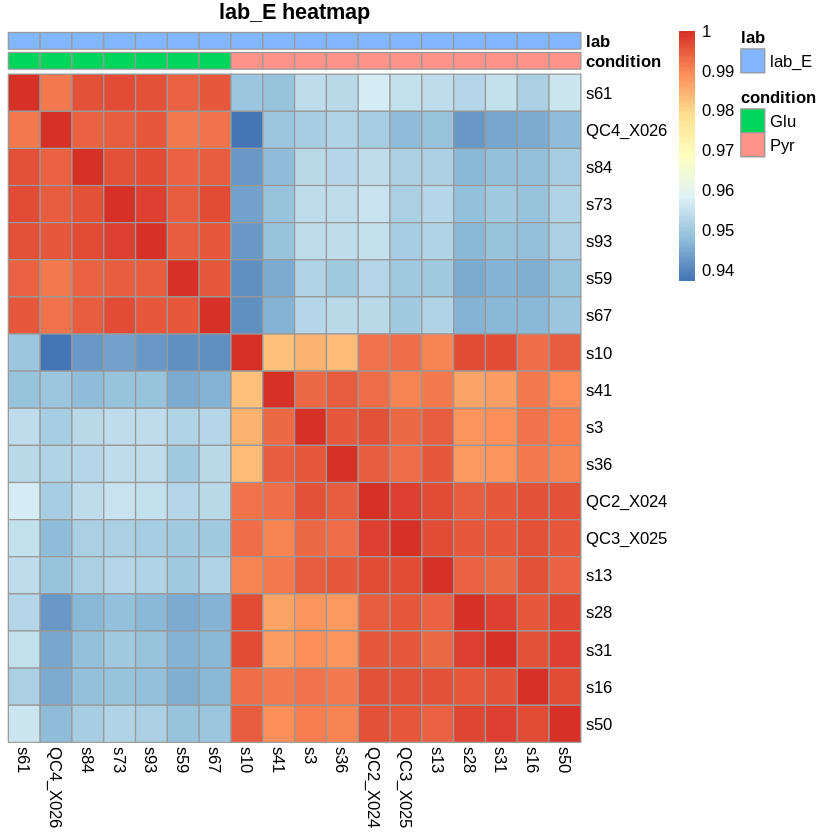

In [30]:
for (dataset in datasets_list) {
  batch_info_all <- NULL

  for (name in labs_list) {
    cat("Processing ", name, " dataset: ", dataset, "\n")
    # create file prefix
    name_prefix <- paste0('/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/', dataset, '/', name, '/')
    data_path <- paste0("/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/balanced/", name, '/')
    plot_name_prefix <- paste0(name_prefix, name)

    # read data
    pg_matrix <- read.csv(paste0(data_path, "protein_groups_matrix.tsv"),sep = "\t", row.names = 1,check.names = FALSE)
    batch_info <- read.csv(paste0(data_path, "metadata.tsv"), sep = "\t") %>%
      mutate(lab = as.factor(lab), condition = as.factor(condition))
    print(colnames(batch_info))
    rownames(batch_info) <- batch_info$file
    counts_table <- read.csv(paste0(data_path, "protein_counts.tsv"),sep = "\t", row.names = 1)

    # select only some samples
    if (dataset == "balanced"){
      sample_names <- batch_info$file
    } else {
      samples_number <- samples_fractions[[dataset]]
      sample_names <- get_sample_names(name, batch_info, samples_number)
    }    
    batch_info <- batch_info[batch_info$file %in% sample_names, ]
    write_tsv(batch_info, 
              paste0(name_prefix, "metadata.tsv"))

    # create design matrix for fedDEqMS
    dummy_df <- model.matrix(~condition - 1, batch_info)
    colnames(dummy_df) <- gsub("condition", "", colnames(dummy_df))
    design <- batch_info %>% select(-condition) %>% cbind(dummy_df)
    write_tsv(design, 
              paste0(name_prefix, "design.tsv"))
    
    # create protein groups matrix
    pg_matrix <- pg_matrix[, batch_info$file]
    pg_matrix <- pg_matrix[apply(pg_matrix, 1, function(x) any(!is.na(x))), ]
    cat("Number of proteins: ", dim(pg_matrix)[1], "   Numer of samples: ", dim(pg_matrix)[2], "\n")
    # apply basic filtering
    pg_matrix <- filter_na_proteins(pg_matrix, batch_info, 'file')    
    write_tsv(pg_matrix %>% rownames_to_column(), 
              paste0(name_prefix, "protein_groups_matrix.tsv"))

    # create precursor counts table
    write_tsv(counts_table %>% rownames_to_column(),
              paste0(name_prefix, "protein_counts.tsv"))

    # create plots
    create_plots(pg_matrix, batch_info, name, plot_name_prefix)

    # add  into metadata for centralized run
    if(is.null(batch_info_all)){
      batch_info_all <- batch_info
      cat("Dimensions of the matrix: ", dim(pg_matrix), "\n")
    } else {
      batch_info_all <- rbind(batch_info_all, batch_info)
      cat("Dimensions of the matrix: ", dim(pg_matrix), "\n")
    }
  }
  batch_info_all <- batch_info_all %>% as.data.frame()
  write_tsv(batch_info_all, 
            paste0('/home/yuliya/repos/cosybio/FedProt/data/bacterial_data/', dataset, '/metadata.tsv'))
}
